In [37]:
import galsim
import time
from usid_processing import parallel_compute
from functools import partial

from utils import *
from modeling import *
from plotting import *

%load_ext autoreload
%autoreload 2

############################################
# Setup
############################################

# Fitting Parameter
n_cpu = 3
RUN_FITTING = True
print_progress = True
draw = True
save = False
use_SE_seg = False
mask_dual = True
mask_strip = True
wid_strip, n_strip = 16, 32

dir_name = "./real"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Image Parameter
patch_Xmin0, patch_Ymin0, patch_Xmax0, patch_Ymax0 = 800, 1800, 1800, 2800  # image coords
# patch_Xmin0, patch_Ymin0, patch_Xmax0, patch_Ymax0 = 800, 600, 1800, 1600   # image coords
# patch_Xmin0, patch_Ymin0, patch_Xmax0, patch_Ymax0 = 3100, 1400, 4100, 2400   # image coords

image_size = 800
pixel_scale = 2.5                                # arcsec/pixel
psf_scale = 2.0                                  # arcsec/pixel

In [3]:
# PSF Parameters
beta = 10                                     # moffat beta, in arcsec
fwhm = 2.28 * pixel_scale                         # moffat fwhm, in arcsec

n = 3.3                     # estimated true power index
frac = 0.3                  # fraction of power law component (from fitting stacked PSF)
theta_0 = 5.                # radius at which power law is flattened, in arcsec (arbitrary)

# Single-power PSF
params_pow = {"fwhm":fwhm, "beta":beta, "frac":frac, "n":n, 'theta_0':theta_0}
psf = PSF_Model(params=params_pow, aureole_model='power')

# Build grid of image for drawing
psf.make_grid(image_size, pixel_scale=pixel_scale)

mu: 460.20 , std: 3.00 , ZP: 27.10 , pix_scale: 2.50


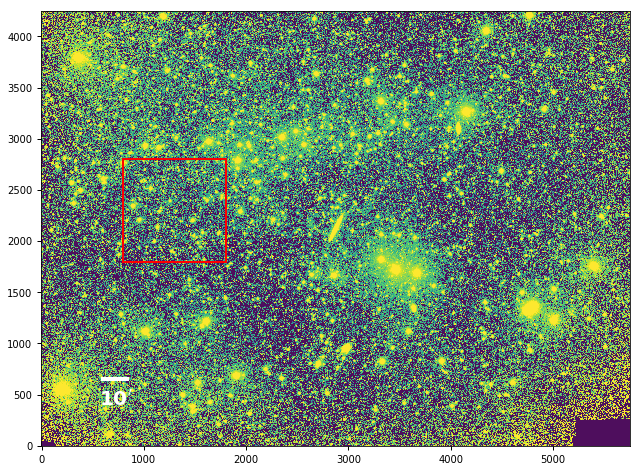

/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10


In [4]:
############################################
# Read
############################################

hdu = fits.open("./data/coadd_SloanG_NGC_5907.fits")[0]
data = hdu.data
header = hdu.header
seeing = 2.5

# Backgroundlevel and estimated std
mu, sigma = np.float(hdu.header["BACKVAL"]), 3
ZP = np.float(hdu.header["REFZP"])
print("mu: %.2f , std: %.2f , ZP: %.2f , pix_scale: %.2f" %(mu, sigma, ZP, pixel_scale))

# Crop image
pad = ((patch_Xmax0-patch_Xmin0)-image_size)//2
patch_Xmin, patch_Ymin = patch_Xmin0 + pad, patch_Ymin0 + pad
patch_Xmax, patch_Ymax = patch_Xmax0 - pad, patch_Ymax0 - pad

image_bounds0 = (patch_Xmin0, patch_Ymin0, patch_Xmax0, patch_Ymax0)
# image_bounds = (patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax)
patch0, seg_patch0 = crop_image(data, image_bounds0, sky_mean=mu, sky_std=sigma, draw=True)

# Read measurement for faint stars from SE 
SE_cat_full = Table.read("./SE_APASS/coadd_SloanG_NGC_5907.cat", format="ascii.sextractor")
SE_cat_full["RMAG_AUTO"] = -2.5*np.log10(SE_cat_full["FLUX_AUTO"]) + ZP
SE_cat = crop_catalog(SE_cat_full, bounds=(patch_Xmin,patch_Ymin,patch_Xmax,patch_Ymax))
SE_cat = SE_cat[SE_cat['RMAG_AUTO']>=15]   # For faint star > 15 mag, use SE flux (won't be modeled)

# Read measurement for bright stars
R_scale = 10
table_res_Rnorm = Table.read("./NGC5907-G-Rnorm_%dpix_15mag_X%dY%d.txt"\
                             %(R_scale, patch_Xmin0, patch_Ymin0), format="ascii")
table_res_Rnorm = crop_catalog(table_res_Rnorm, bounds=(patch_Xmin0, patch_Ymin0, patch_Xmax0, patch_Ymax0))

Threosholds: [27. 24.] [ 147096.32583489 2331319.65451752] [  6.8287563  108.22849365]
# of medium bright (flux:1.5e+05~1.7e+06) stars: 38 
# of very bright (flux>2.4e+06) stars : 6
Not many bright stars, will draw in serial.


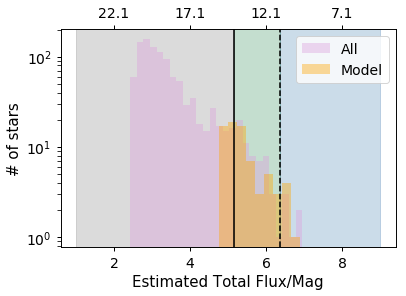

In [21]:
# Star Distribution
############################################

# Positions & Flux of faint stars from SE
star_pos1 = np.vstack([SE_cat['X_IMAGE'],
                       SE_cat['Y_IMAGE']]).T - [patch_Xmin, patch_Ymin]
Flux1 = np.array(SE_cat['FLUX_AUTO'])

# Positions & Flux (estimate) of faint stars from measured norm
star_pos2 = np.vstack([table_res_Rnorm['X_IMAGE'],
                       table_res_Rnorm['Y_IMAGE']]).T - [patch_Xmin, patch_Ymin]
sky_local = np.median(table_res_Rnorm['sky'].data)
z_norm = table_res_Rnorm['mean'].data - mu
Flux2 = psf.I2Flux(z_norm, r=R_scale)

# Thresholds affecting speed and accuracy depending on the actual PSF, noise level, and magnitude distribution of stars.
# Non-bright stars are rendered with moffat only in advance. Very bright stars are rendered in real space.
F_bright = 1e5 #6e4
F_verybright = 5e6 #2e6
Flux_threshold = np.array([F_bright, F_verybright])

# alternatively
SB_threshold = np.array([27.,23])
SB_threshold = np.array([27.,24])
Flux_threshold = psf.SB2Flux(SB_threshold, BKG=0, ZP=ZP, r=R_scale)
z_threshold = psf.Flux2I(Flux_threshold, r=R_scale)
print("Threosholds:", SB_threshold, Flux_threshold, z_threshold)

# Combine 
star_pos = np.vstack([star_pos1, star_pos2])
Flux = np.concatenate([Flux1, Flux2])
stars_all = Stars(star_pos, Flux, Flux_threshold=Flux_threshold)
stars_all.plot_flux_dist(label='All', color='plum')

# Bright stars in model
stars0 = Stars(star_pos2, Flux2, Flux_threshold=Flux_threshold, z_norm=z_norm, r_scale=R_scale)
stars0 = stars0.remove_outsider(image_size, d=[12, 24], verbose=True)
stars0.plot_flux_dist(label='Model', color='orange', ZP=ZP)

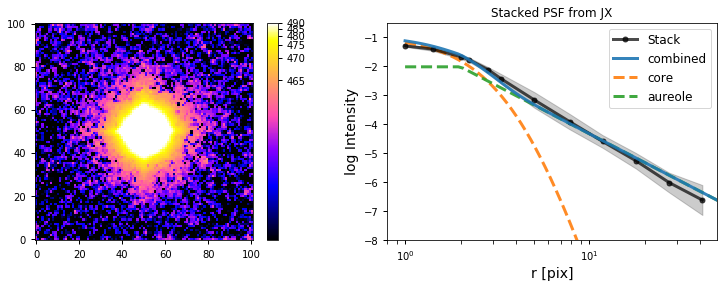

In [10]:
PSF_JX_p = fits.getdata("./median_psf_patch.fits") * 1e5 + mu

fig = plt.figure(figsize=(13,4))
ax1 = plt.subplot(121)
im = ax1.imshow(PSF_JX_p, norm=norm1, vmin=mu); colorbar(im)

ax2 = plt.subplot(122)
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(abs(PSF_JX_p-mu)/1e6, cen=(50,50), 
                                              ZP=ZP, sky_mean=0, sky_std=1e-6,
                                              dr=1, lw=3, pixel_scale=pixel_scale,
                                              xunit="pix", yunit="Intensity", color="k", label='Stack',
                                              scatter=False, core_undersample=True)
plt.title("Stacked PSF from JX")
psf.plot1D()

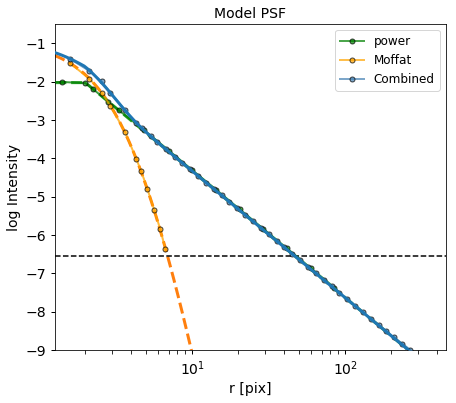

In [16]:
# Generate core and aureole PSF
psf_c = psf.generate_core()
psf_e, psf_size = psf.generate_aureole(contrast=1e6, psf_range=image_size)
star_psf = (1-frac) * psf_c + frac * psf_e

# Galsim 2D model averaged in 1D
Amp_m = psf.Flux2Amp(Flux).max()
contrast = Amp_m / sigma
psf.plot_model_galsim(psf_c, psf_e, image_size, contrast=contrast)

In [48]:
v = np.array([n, 3, 3, 3, 3, 60, 120, 200, 320, 884, 3])

In [51]:
v[9]

884.0

In [22]:
# Setup Image
############################################
# Make noise image
noise_image = make_noise_image(image_size, sigma)

# Make sky background and dim stars
image_base = make_base_image(image_size, stars_all, psf_base=star_psf, pad=pad)

# Cutout of data
image0 = patch0.copy()
image = image0[pad:-pad,pad:-pad]

Generate noise background w/ stddev = 3
Generate base image of faint stars (flux < 1.5e+05).
Total Time: 0.778s


Mask inner regions of stars in dual mode:  S/N > 2.5 / r < 24 (12) pix 
Use sky strips crossing very bright stars


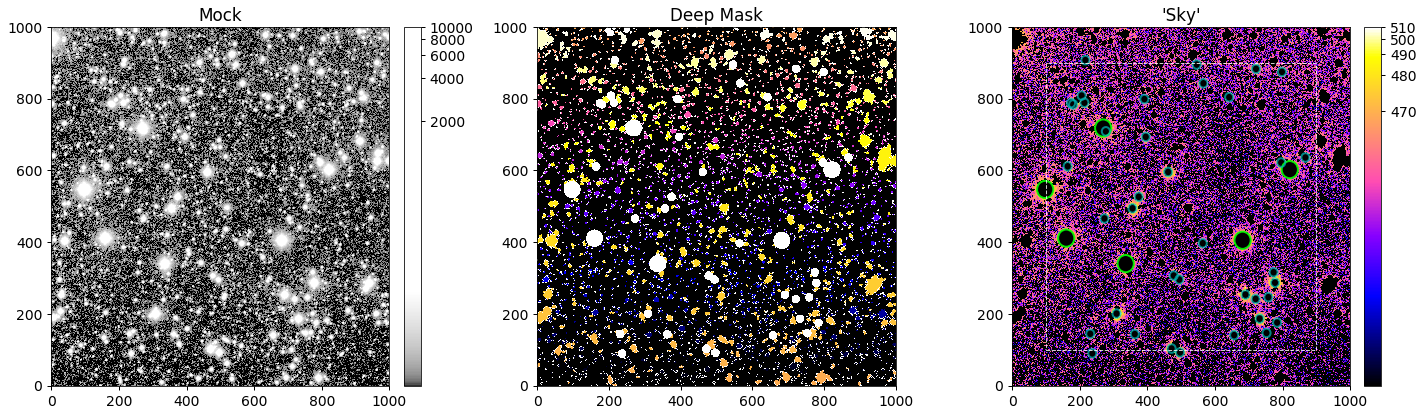

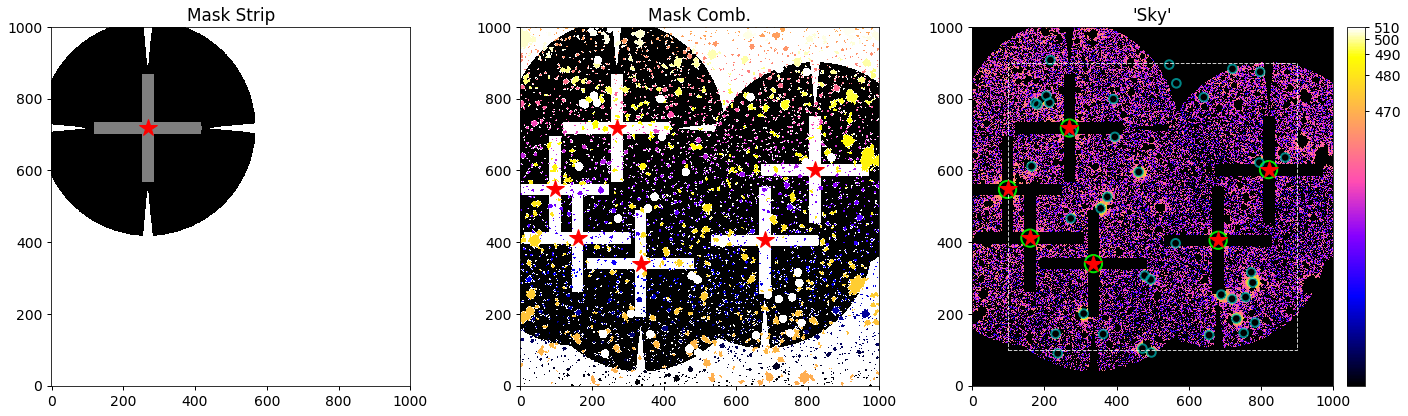

In [24]:
# Make Mask
############################################
mask = Mask(image0, stars0, image_size, pad=pad, mu=mu)

# Core mask
r_core_s = [24, 12]
mask.make_mask_map_dual(r_core_s, sn_thre=2.5, draw=True, n_dilation=1)

# Strip + Cross mask
mask.make_mask_strip(wid_strip, n_strip, dist_strip=300, clean=True, draw=True)
stars_b = mask.stars_new

In [25]:
brightest_only = False

if brightest_only:
    stars_vb = Stars(stars_b.star_pos_verybright,
                     stars_b.Flux_verybright,
                     Flux_threshold=stars_b.Flux_threshold,
                     z_norm=stars_b.z_norm_verybright, r_scale=R_scale)
    stars = stars_vb
else:
    stars = stars_b


Total Time: 0.141s


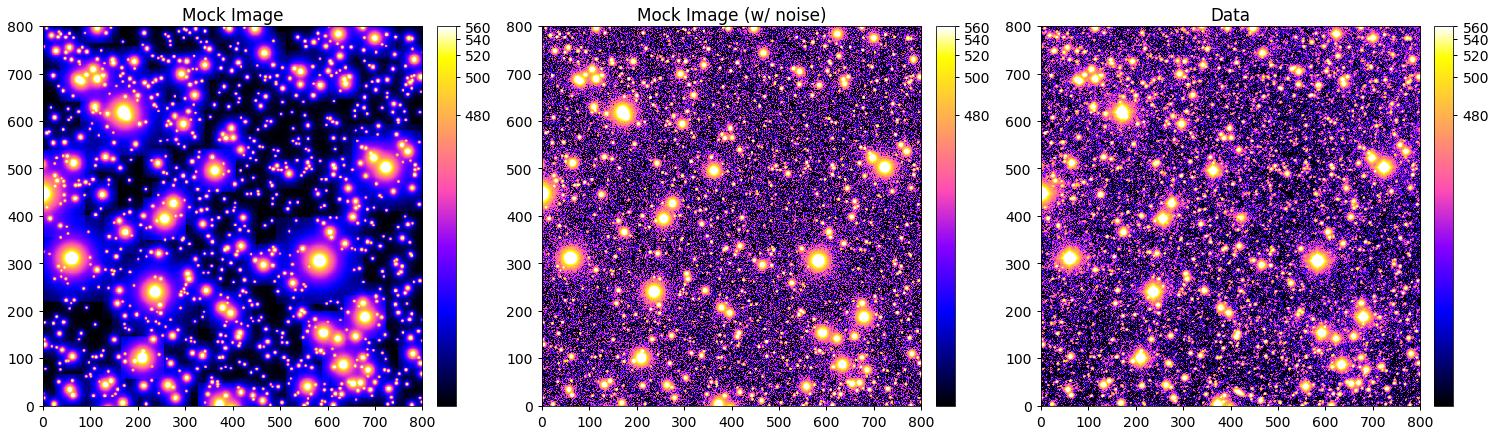

In [26]:
# Generate Image Test
############################################

psf.update({'n':3.3})

start = time.time()
image_tri0 = generate_image_by_znorm(psf, stars, psf_scale=pixel_scale, parallel=False, draw_real=False)
image_tri0 = image_tri0 + image_base + mu
end = time.time()
print("\nTotal Time: %.3fs"%(end-start))
    
# Draw
if draw:
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(21,7))
    im = ax1.imshow(image_tri0, vmin=mu, vmax=mu+100, norm=norm1, cmap="gnuplot2")
    ax1.set_title("Mock Image"); colorbar(im)
    im = ax2.imshow(image_tri0 + noise_image, vmin=mu, vmax=mu+100, norm=norm1, cmap="gnuplot2")    
    ax2.set_title("Mock Image (w/ noise)"); colorbar(im)
    im = ax3.imshow(image, vmin=mu, vmax=mu+100, norm=norm1, cmap="gnuplot2")
    ax3.set_title("Data"); colorbar(im)
    plt.tight_layout()  

In [28]:
%%timeit
psf.update({'n':2.5})
image_tri0 = generate_image_by_znorm(psf, stars, psf_scale=pixel_scale, parallel=False, draw_real=True)

445 ms ± 50.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


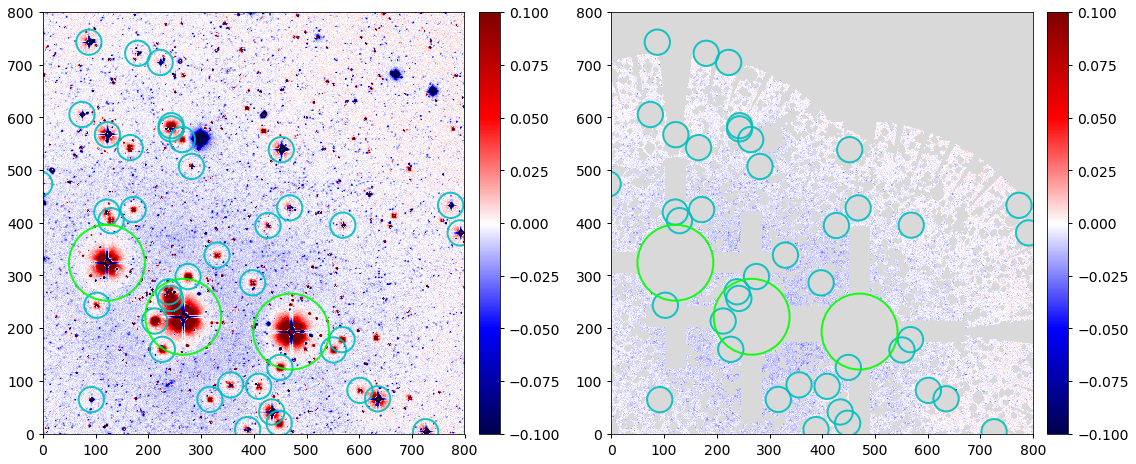

In [487]:
img_diff = (image_tri0-image)/image
plt.figure(figsize=(16,8))
ax1=plt.subplot(121)
im = plt.imshow(img_diff, vmin=-0.1, vmax=0.1, origin="lower", cmap="seismic")
colorbar(im)

ax2=plt.subplot(122)
img_diff[mask.mask_comb] = np.nan
im = plt.imshow(img_diff, vmin=-0.1, vmax=0.1, origin="lower", cmap="seismic")
colorbar(im)

aper1 = CircularAperture(stars.star_pos_medbright, r=24)
aper2 = CircularAperture(stars.star_pos_verybright, r=72)
for ax in [ax1,ax2]:
    aper1.plot(color='c',lw=2,alpha=0.9,axes=ax)
    aper2.plot(color='lime',lw=2,alpha=0.9,axes=ax)

plt.tight_layout()

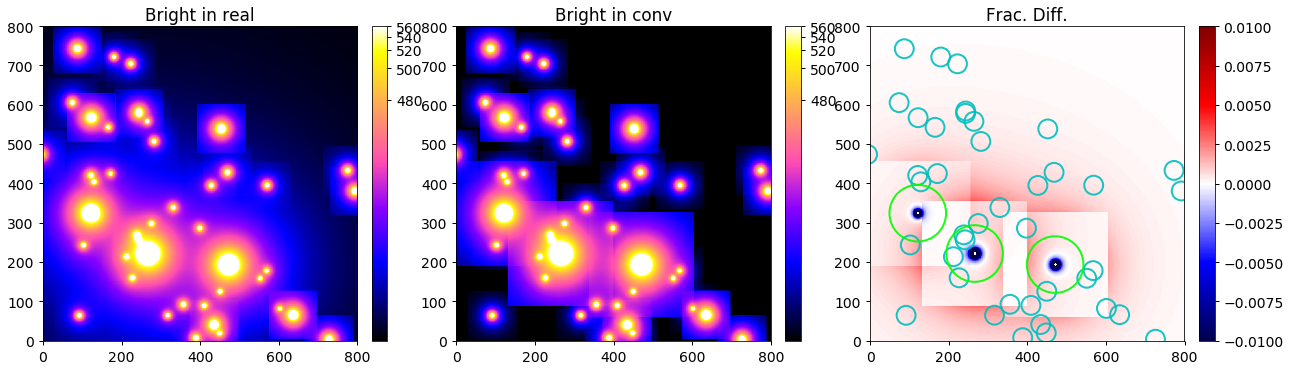

In [498]:
# Difference between real vs conv
psf.update({'n':3.})

img1 = generate_image_by_znorm(psf, stars, psf_scale=pixel_scale, draw_real=True)
img2 = generate_image_by_znorm(psf, stars, psf_scale=pixel_scale, draw_real=False)
img1[img1>5.1e4] = 5.1e4
img2[img2>5.1e4] = 5.1e4

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(21,7))
im = ax1.imshow(img1+mu, vmin=mu, vmax=mu+100, norm=norm1, cmap="gnuplot2")
ax1.set_title("Bright in real"); colorbar(im)
im = ax2.imshow(img2+mu, vmin=mu, vmax=mu+100, norm=norm1, cmap="gnuplot2")    
ax2.set_title("Bright in conv"); colorbar(im)
im = ax3.imshow((img1-img2)/mu, vmin=-0.01, vmax=0.01, cmap="seismic")
ax3.set_title("Frac. Diff."); colorbar(im)

aper1.plot(color='c',lw=2,alpha=0.9,axes=ax3)
aper2.plot(color='lime',lw=2,alpha=0.9,axes=ax3)

Estimate of Background: (460.780, 2.433)


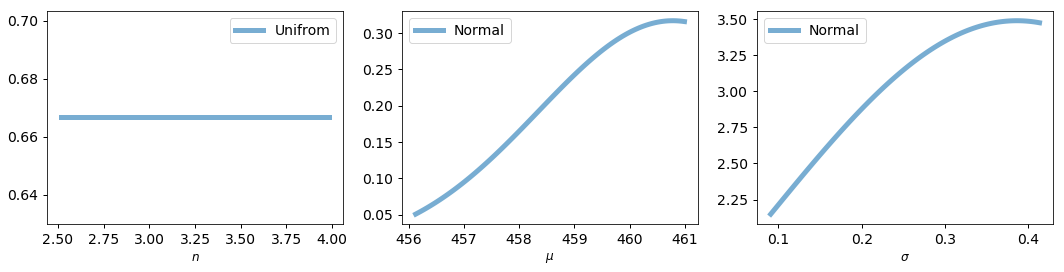

In [32]:
# Priors and Likelihood Models for Fitting
############################################

if mask_strip is True:
    mask_fit = mask.mask_comb
else:
    mask_fit = mask.mask_deep
    
X = np.array([psf.xx,psf.yy])
Y = image[~mask_fit].copy().ravel()

# Estimated mu and sigma used as prior
Y_clip = sigma_clip(image[~mask.mask_deep], sigma=3, maxiters=10)
mu_patch, std_patch = np.mean(Y_clip), np.std(Y_clip)
print("Estimate of Background: (%.3f, %.3f)"%(mu_patch, std_patch))

# Make Priors
Prior_n = stats.uniform(loc=2.5, scale=1.5)                                      # n : 2.5-4
Prior_mu = stats.truncnorm(a=-2, b=0.1, loc=mu_patch, scale=std_patch)           # mu
Prior_sigma = stats.truncnorm(a=-1, b=0.1, loc=np.log10(std_patch), scale=0.3)   # sigma 

Priors = [Prior_n, Prior_mu, Prior_sigma]
prior_tf = build_priors(Priors)

labels = [r'$n$', r'$\mu$', r'$\sigma$']
draw_prior(Priors, xlabels=labels, plabels=['Unifrom','Normal','Normal'])
ndim = len(labels)

def loglike(v):
    n, mu = v[:-1]
    sigma = 10**v[-1]
    
    psf.update({'n':n})
    
    image_tri = generate_image_by_znorm(psf, stars, psf_scale=pixel_scale, parallel=False, draw_real=False)
    image_tri = image_tri + image_base + mu
    
    ypred = image_tri[~mask_fit].ravel()
    residsq = (ypred - Y)**2 / sigma**2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma**2))
    
    if not np.isfinite(loglike):
        loglike = -1e100
        
    return loglike

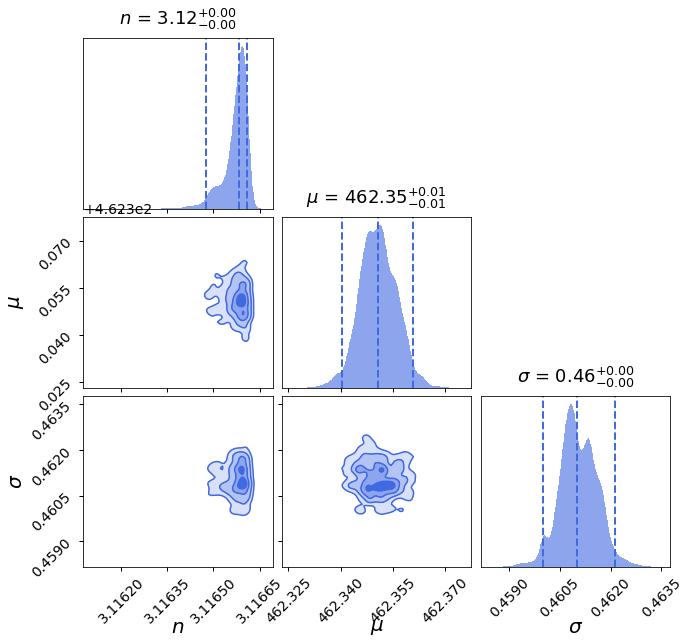

In [674]:
# Run Fitting
pdsampler = Run_Dynamic_Nested_Fitting(loglike, prior_tf, ndim, nlive_init=60, nlive_batch=20)
pdres = pdsampler.results

# Plot Result
fig, axes = dyplot.cornerplot(pdres, labels=labels, 
                              color="royalblue", truth_color="indianred",
                              title_kwargs={'fontsize':18, 'y': 1.04},
                              label_kwargs={'fontsize':20}, show_titles=True, 
                              fig=plt.subplots(ndim, ndim, figsize=(10, 9)))

Bakground : 462.35 +/- 2.89
Reduced Chi^2: 0.96591


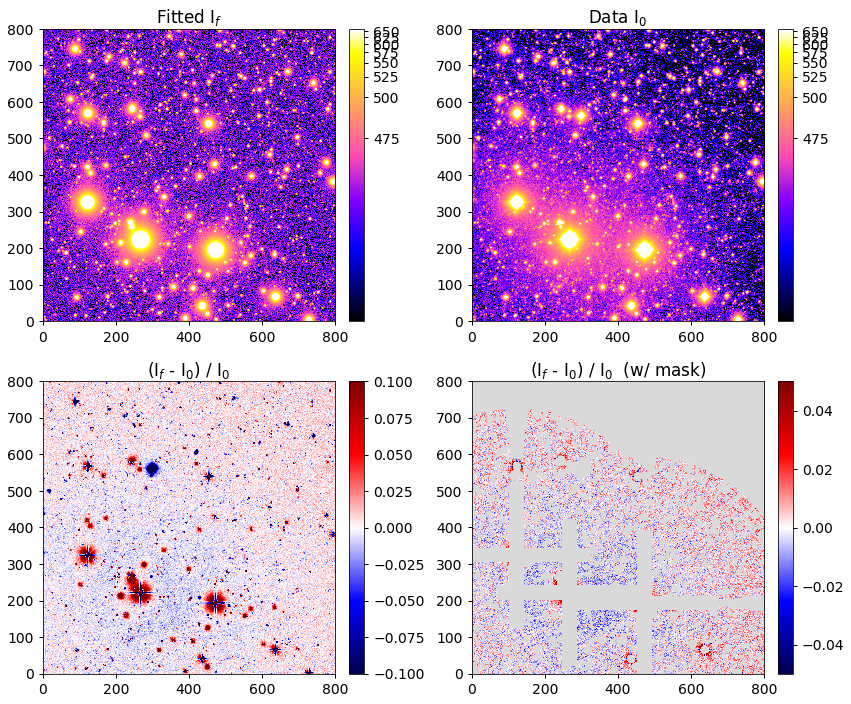

In [715]:
image_fit, noise_fit, pmed = make_image_fit(pdres, psf, stars0, image_base)
cal_reduced_chi2(image_fit[~mask_fit].ravel(), Y, sigma=10**pmed[-1], n_param=3)
draw_comparison_fit_data(image_fit, image, noise_fit, mask_fit, vmin=460)

Run Nested Fitting for the image... Dim of params: 3
Opening pool: # of CPU used: 3


iter: 2236 | batch: 2 | bound: 29 | nc: 2 | ncall: 7458 | eff(%): 29.981 | loglstar: -959135.099 < -959131.950 < -959133.107 | logz: -959148.227 +/-  0.544 | stop:  4.903                            


Finish Fitting! Total time elapsed: 1.21e+03s


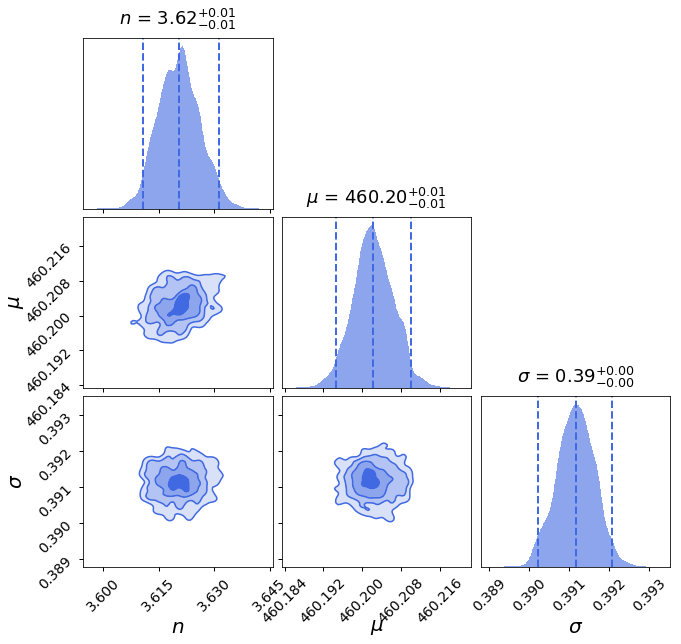

In [43]:
# Run Fitting
pdsampler = Run_Dynamic_Nested_Fitting(loglike, prior_tf, ndim, nlive_init=100, nlive_batch=50)
pdres = pdsampler.results

# Plot Result
fig, axes = dyplot.cornerplot(pdres, labels=labels, 
                              color="royalblue", truth_color="indianred",
                              title_kwargs={'fontsize':18, 'y': 1.04},
                              label_kwargs={'fontsize':20}, show_titles=True, 
                              fig=plt.subplots(ndim, ndim, figsize=(10, 9)))

Bakground : 460.20 +/- 2.46
Reduced Chi^2: 0.99984


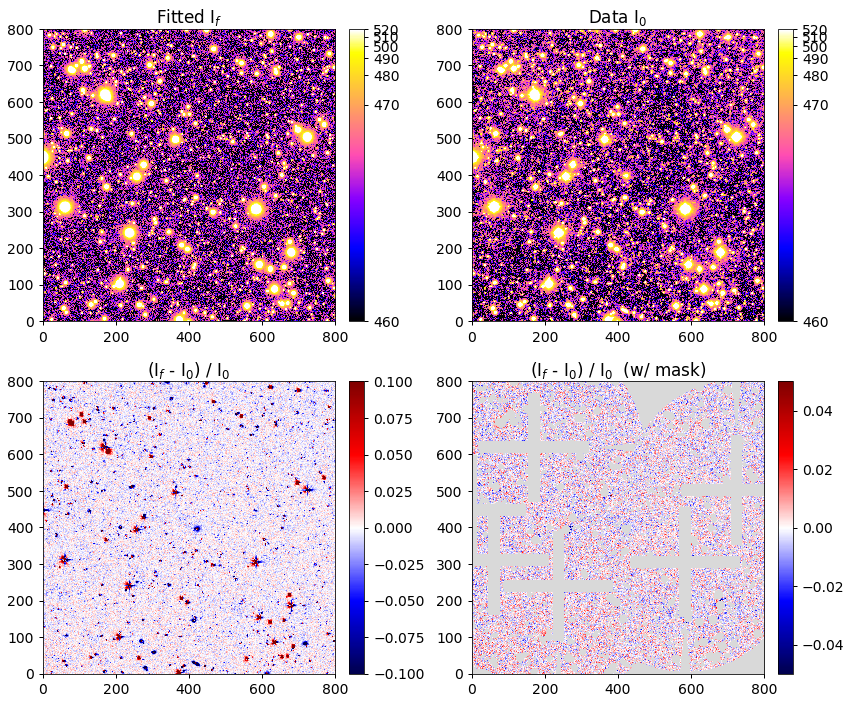

In [44]:
image_fit, noise_fit, pmed = generate_image_fit(pdres, psf, stars0, image_base)
cal_reduced_chi2(image_fit[~mask_fit].ravel(), Y, sigma=10**pmed[-1], n_param=3)
draw_comparison_fit_data(image_fit, image, noise_fit, mask_fit, vmin=460, vmax=520)

In [47]:
save_nested_fitting_result(pdres, filename='./real/NGC5907-G-fit_best_X%dY%d.res'%(patch_Xmin0, patch_Ymin0))

## Historical Results

#### Region: [3100,1400,4100,2400]
#### Fitted patch: 800 X 800  
#### Dual Mask : S/N = 3   +   $\bf R_{core} = 1\,(0.5)\,arcmin$   +   Gaussian Noise

Run Nested Fitting for the image... Dim of paramas: 4
Opening pool: # of CPU used: 3


iter: 3444 | batch: 2 | bound: 800 | nc: 416 | ncall: 134424 | eff(%):  2.562 | loglstar: -654291.984 < -654287.469 < -654290.868 | logz: -654315.495 +/-  0.718 | stop:  4.397                       


Finish Fitting! Total time elapsed: 1.5e+04s


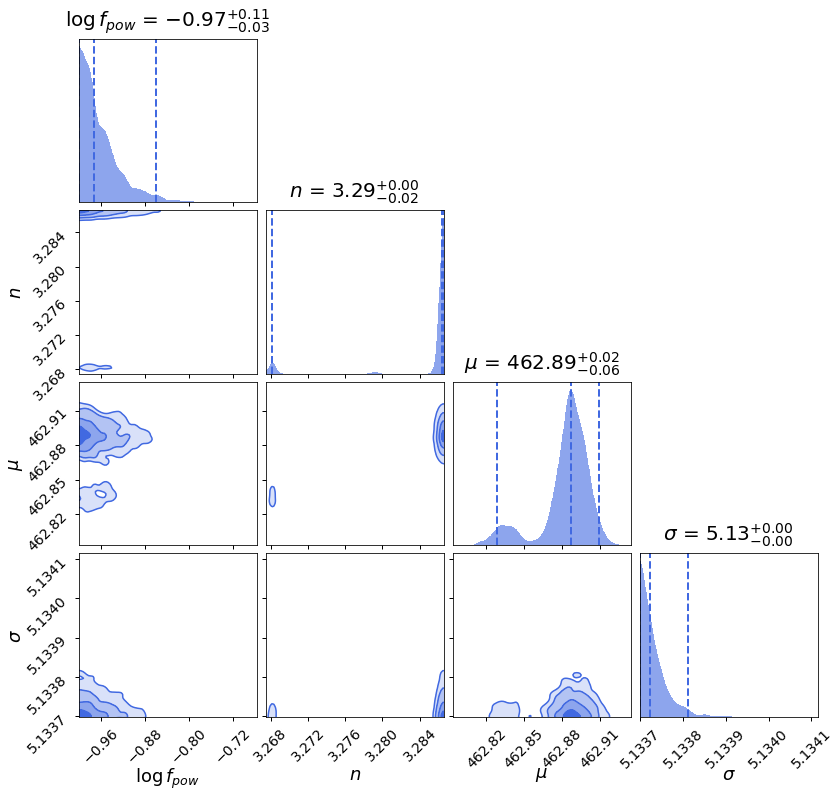

In [171]:
############################################
# Fitting
############################################

if RUN_FITTING:
    start = time.time()
    pdsampler = Run_Dynamic_Nested_Fitting(loglike, prior_tf, ndim=4, 
                                           nlive_init=100, nlive_batch=50, maxbatch=2)
    end = time.time()
    print("Finish Fitting! Total time elapsed: %.3gs"%(end-start))
    
    pdres = pdsampler.results

    # Plot Result
    fig, axes = dyplot.cornerplot(pdres, show_titles=True, 
                                  color="royalblue", 
                                  labels=labels,
                                  title_kwargs={'fontsize':20, 'y': 1.04}, 
                                  label_kwargs={'fontsize':18},
                                  fig=plt.subplots(4, 4, figsize=(12, 11)))

In [172]:
chi2_reduced = cal_reduced_chi2(pdres, Y)

Reduced Chi^2: 0.35933


In [231]:
# Difference between real vs conv
pmed, pmean, pcov = get_params_fit(pdres)
logf_fit, n_fit, mu_fit, sigma_fit = pmed

img_fit = generate_image_galsim_scale(frac=10**logf_fit, n=n_fit, mu=mu_fit, 
                                      star_pos=star_pos, scale=z_norm, parallel=True, draw_real = True)
noise_fit = make_noise_image(image_size, sigma_fit**2)
img_fit += noise_fit

fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(12,10))
im = ax1.imshow(img_fit, vmin=mu_fit, vmax=mu_fit+100, norm=norm1, cmap="gnuplot2")
colorbar(im)
im = ax2.imshow(image, vmin=mu_fit, vmax=mu_fit+100, norm=norm1, cmap="gnuplot2")    
colorbar(im)
diff = (img_fit-image)/image
im = ax3.imshow(diff, vmin=-0.1, vmax=0.1, cmap="seismic")
diff = (img_fit-image)/image
colorbar(im)

aper1 = CircularAperture(star_pos[medbright], r=r_core_B)
aper2 = CircularAperture(star_pos[verybright], r=r_core_A)
aper1.plot(color='c',lw=2,alpha=0.9,axes=ax3)
aper2.plot(color='lime',lw=2,alpha=0.9,axes=ax3)

diff[mask_fit] = np.nan
im = ax4.imshow(diff, vmin=-0.05, vmax=0.05, cmap="seismic")
colorbar(im)

ax1.set_title("Fitted I$_f$")
ax2.set_title("Data I$_0$")
ax3.set_title("(I$_f$ - I$_0$) / I$_0$")
ax4.set_title("(I$_f$ - I$_0$) / I$_0$  (w/ mask)")

plt.tight_layout()
plt.savefig("Comparison_fit_data-G-X%dY%d.png"%(patch_Xmin0, patch_Ymin0),dpi=120)

In [232]:
# plot_fit_PSF(pdres, n_bootstrap=500, image_size=image_size)

In [190]:
save_nested_fitting_result(pdres, filename='./NGC5907-G-fit_best_X3100Y1400.res')

Run Nested Fitting for the image... Dim of params: 4
Opening pool: # of CPU used: 3


iter: 2325 | batch: 2 | bound: 35 | nc: 1 | ncall: 8749 | eff(%): 26.574 | loglstar: -580852.705 < -580849.612 < -580850.930 | logz: -580867.424 +/-  0.572 | stop:  4.940                            


Finish Fitting! Total time elapsed: 1.23e+03s
Finish Fitting! Total time elapsed: 1.23e+03s


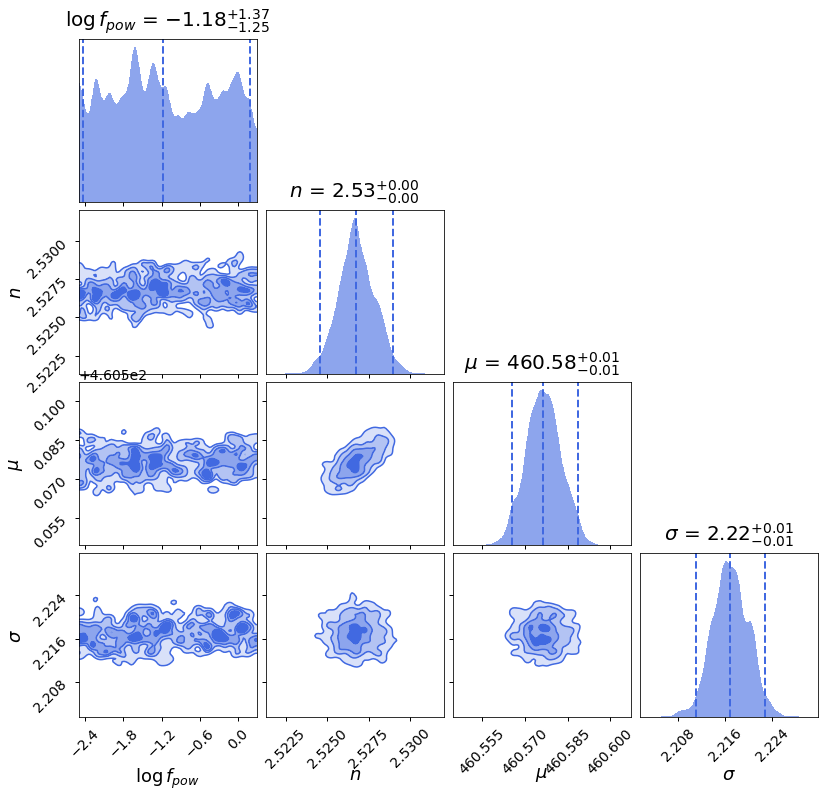

In [38]:
############################################
# Fitting
############################################

if RUN_FITTING:
    start = time.time()
    pdsampler = Run_Dynamic_Nested_Fitting(loglike, prior_tf, ndim=4, 
                                           nlive_init=100, nlive_batch=50, maxbatch=2)
    end = time.time()
    print("Finish Fitting! Total time elapsed: %.3gs"%(end-start))
    
    pdres = pdsampler.results

    # Plot Result
    fig, axes = dyplot.cornerplot(pdres, show_titles=True, 
                                  color="royalblue", 
                                  labels=labels,
                                  title_kwargs={'fontsize':20, 'y': 1.04}, 
                                  label_kwargs={'fontsize':18},
                                  fig=plt.subplots(4, 4, figsize=(12, 11)))

Generate noise background w/ stddev = 2.22


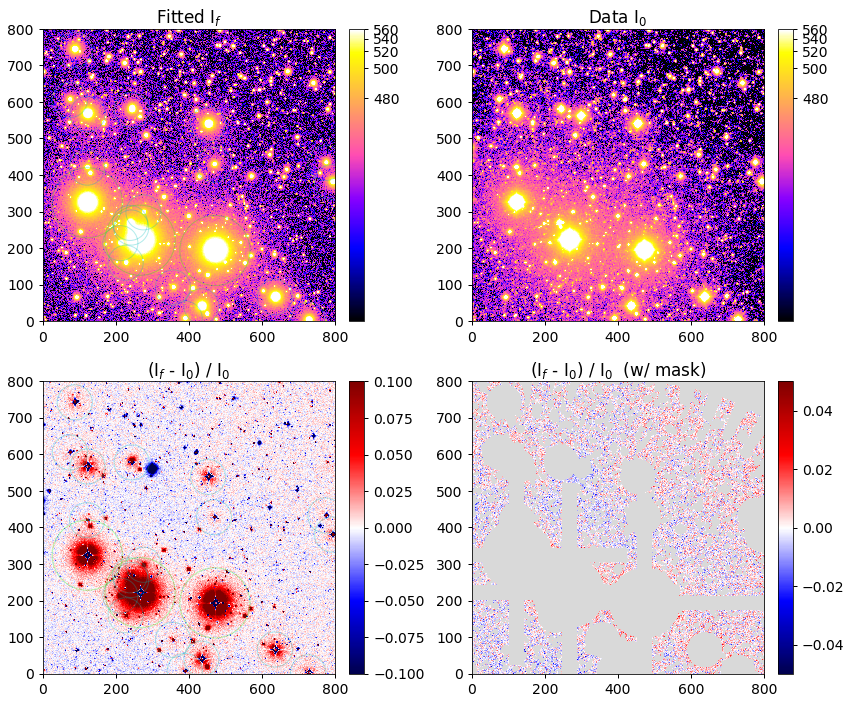

In [48]:
# Difference between real vs conv
pmed, pmean, pcov = get_params_fit(pdres)
logf_fit, n_fit, mu_fit, sigma_fit = pmed

img_fit = generate_image_galsim_scale(frac=10**logf_fit, n=n_fit, mu=mu_fit, 
                                      star_pos=star_pos, scale=z_norm, parallel=True, draw_real = True)
noise_fit = make_noise_image(image_size, sigma_fit)
img_fit += noise_fit

fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(12,10))
im = ax1.imshow(img_fit, vmin=mu_fit, vmax=mu_fit+100, norm=norm1, cmap="gnuplot2")
colorbar(im)
im = ax2.imshow(image, vmin=mu_fit, vmax=mu_fit+100, norm=norm1, cmap="gnuplot2")    
colorbar(im)
diff = (img_fit-image)/image
im = ax3.imshow(diff, vmin=-0.1, vmax=0.1, cmap="seismic")
diff = (img_fit-image)/image
colorbar(im)

aper1 = CircularAperture(star_pos[medbright], r=r_core_B)
aper2 = CircularAperture(star_pos[verybright], r=r_core_A)
for ax in [ax1,ax3]:
    aper1.plot(color='c',lw=1,alpha=0.3,axes=ax)
    aper2.plot(color='lime',lw=1,alpha=0.3,axes=ax)

diff[mask_fit] = np.nan
im = ax4.imshow(diff, vmin=-0.05, vmax=0.05, cmap="seismic")
colorbar(im)

ax1.set_title("Fitted I$_f$")
ax2.set_title("Data I$_0$")
ax3.set_title("(I$_f$ - I$_0$) / I$_0$")
ax4.set_title("(I$_f$ - I$_0$) / I$_0$  (w/ mask)")

plt.tight_layout()
# plt.savefig("Comparison_fit_data-G-X%dY%d.png"%(patch_Xmin0, patch_Ymin0),dpi=120)

In [43]:
chi2_reduced = cal_reduced_chi2(pdres, Y)

Reduced Chi^2: 1.00763


Fitting (mean):  [ -1.15175395   2.78499813 461.93239078   2.36513342]
Fitting (median):  [ -1.15553728   2.78501443 461.93224525   2.36520676]
2643214.6874619466 1057.661772445025
2641476.6975351567 1057.694568483241


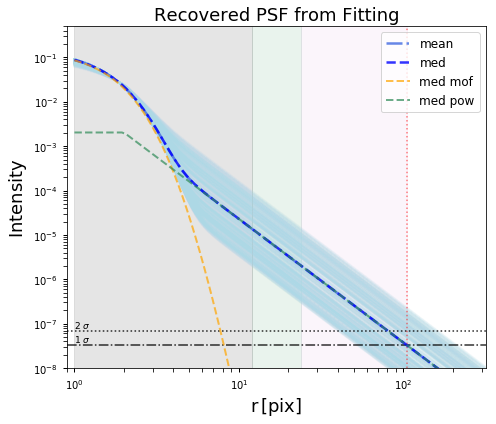

In [42]:
plot_fit_PSF(pdres, n_bootstrap=500, image_size=image_size)

#### Region: [800,800,1800,1800] 
#### Fitted patch: 800 X 800  
#### Dual Mask : S/N = 3   +   $\bf R_{core} = 1\,(0.5)\,arcmin$   +   Gaussian Noise

Run Nested Fitting for the image... Dim of paramas: 4
Opening pool: # of CPU used: 3


iter: 2426 | batch: 2 | bound: 70 | nc: 5 | ncall: 13663 | eff(%): 17.756 | loglstar: -484303.150 < -484300.227 < -484301.503 | logz: -484318.615 +/-  0.576 | stop:  4.146                           


Finish Fitting! Total time elapsed: 1.26e+03s


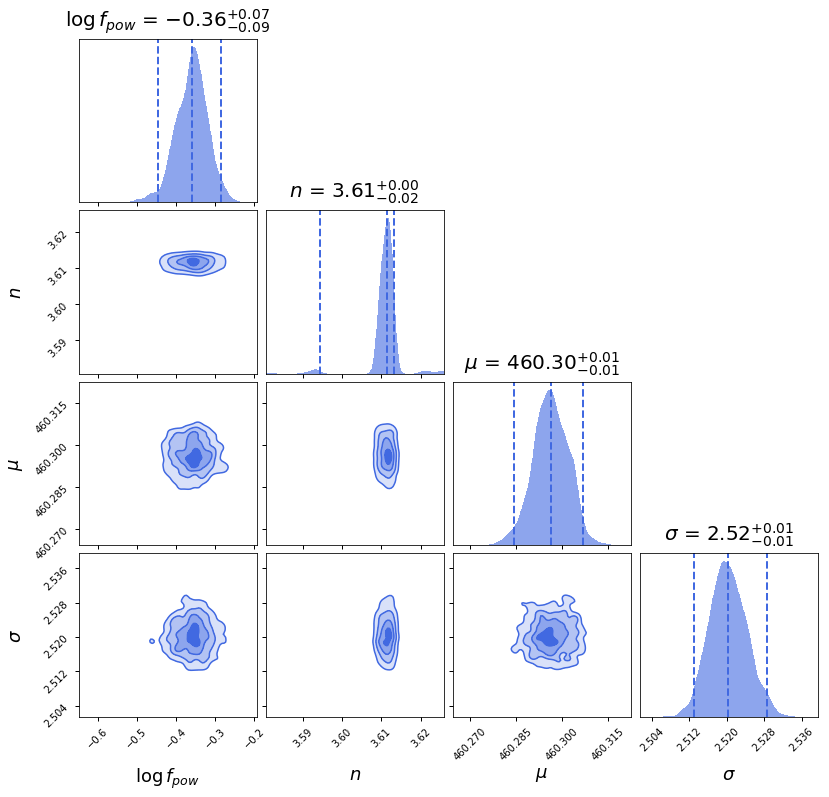

In [30]:
if RUN_FITTING:
    start = time.time()
    pdsampler = Run_Dynamic_Nested_Fitting(loglike, prior_tf, ndim=4, 
                                           nlive_init=100, nlive_batch=50, maxbatch=2)
    end = time.time()
    print("Finish Fitting! Total time elapsed: %.3gs"%(end-start))
    
    pdres = pdsampler.results

    # Plot Result
    fig, axes = dyplot.cornerplot(pdres, show_titles=True, 
                                  color="royalblue", 
                                  labels=labels,
                                  title_kwargs={'fontsize':20, 'y': 1.04}, 
                                  label_kwargs={'fontsize':18},
                                  fig=plt.subplots(4, 4, figsize=(12, 11)))

In [225]:
chi2_reduced = cal_reduced_chi2(pdres, Y)

Reduced Chi^2: 1.00189


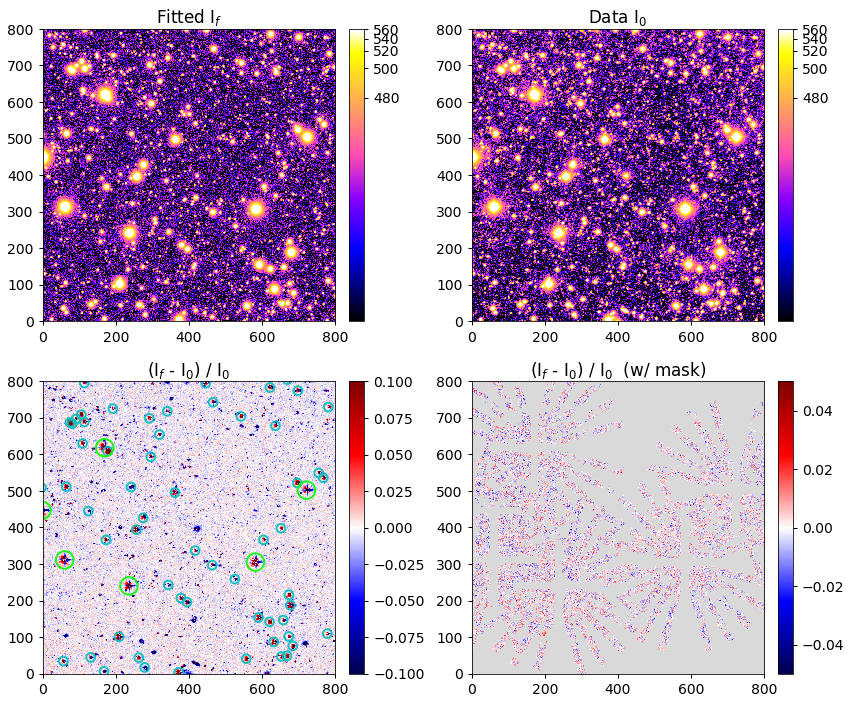

In [230]:
# Difference between real vs conv
pmed, pmean, pcov = get_params_fit(pdres)
logf_fit, n_fit, mu_fit, sigma_fit = pmed

img_fit = generate_image_galsim_scale(frac=10**logf_fit, n=n_fit, mu=mu_fit, 
                                      star_pos=star_pos, scale=z_norm, parallel=True, draw_real = True)
noise_fit = make_noise_image(image_size, sigma_fit**2)
img_fit += noise_fit

fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(12,10))
im = ax1.imshow(img_fit, vmin=mu_fit, vmax=mu+100, norm=norm1, cmap="gnuplot2")
colorbar(im)
im = ax2.imshow(image, vmin=mu_fit, vmax=mu+100, norm=norm1, cmap="gnuplot2")    
colorbar(im)
diff = (img_fit-image)/image
im = ax3.imshow(diff, vmin=-0.1, vmax=0.1, cmap="seismic")
diff = (img_fit-image)/image
colorbar(im)
aper1.plot(color='c',lw=2,alpha=0.9,axes=ax3)
aper2.plot(color='lime',lw=2,alpha=0.9,axes=ax3)

diff[mask_fit] = np.nan
im = ax4.imshow(diff, vmin=-0.05, vmax=0.05, cmap="seismic")
colorbar(im)

ax1.set_title("Fitted I$_f$")
ax2.set_title("Data I$_0$")
ax3.set_title("(I$_f$ - I$_0$) / I$_0$")
ax4.set_title("(I$_f$ - I$_0$) / I$_0$  (w/ mask)")

plt.tight_layout()
plt.savefig("Comparison_fit_data-G-X800Y1800.png",dpi=120)

Fitting (mean):  [-3.38935312e-01  3.61059778e+00  4.60301111e+02  2.52037734e+00]
Fitting (median):  [-3.36250690e-01  3.61124376e+00  4.60301204e+02  2.52049825e+00]
217514.50953953736 140.95116325127447
218661.20297802772 140.95792510608686


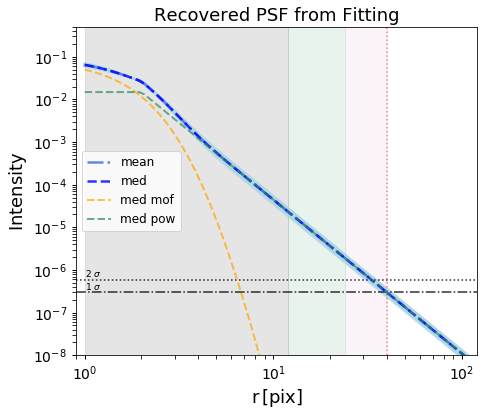

In [233]:
plot_fit_PSF(pdres, n_bootstrap=1000, image_size=image_size)

In [234]:
save_nested_fitting_result(pdres, filename='./NGC5907-G-fit_best_X%dY%d.res'%(patch_Xmin0, patch_Ymin0))